In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
import sys
import copy
from matplotlib import pylab

In [283]:
#Wczytywanie i podział danych
data = pd.read_csv("2018_paths/GlebiaChallengera.csv")
print("Ilość punktów wynosi: " + str(len(data)))
#step = int(input("Podaj co który punkt zostanie użyty do interpolacji "))
#step = 100
mainData = []

points = 64
step = int(len(data)/(points-1))

for i in range(0, len(data), step):
    mainData.append([data['x'][i], data['y'][i]])

#print(data)
#print(mainData, len(mainData))

Ilość punktów wynosi: 512


In [284]:
#Interpolacja La Grange'a
#Obliczanie funkcji
fun = 0
for i in range(0, len(mainData)):
    denominator = 1
    poly = np.poly1d([1])
    for j in range(0, len(mainData)):
        if(i != j):
            p1 = np.poly1d([1,-mainData[j][0]])
            poly *= p1
            value = (mainData[i][0] - mainData[j][0])
            denominator *= value
    poly /= denominator
    fun += poly * mainData[i][1]
#print(fun)

C:\Users\Jasiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':


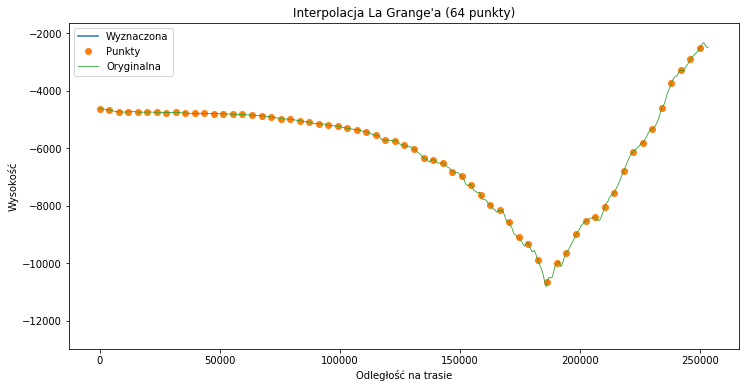

In [285]:
#Tworzenie wykresu
x = np.array([x[0] for x in mainData])
y = np.array([x[1] for x in mainData])

x_new = np.linspace(x[0], x[-1], 50)
y_new = fun(x_new)
top = max(data['y'])
if top > 0:
    top *= 1.3
else:
    top *= 0.7 
bottom = min(data['y'])*1.2
if bottom > -10:
    bottom = -10
plt.figure(figsize=(12,6))
plt.plot(x_new, y_new, label = 'Wyznaczona')
plt.plot(x,y,'o', label = 'Punkty')
plt.ylim(bottom, top)
plt.plot(data['x'], data['y'], linewidth=0.8, label = 'Oryginalna')
pylab.title('Interpolacja La Grange\'a (64 punkty)')
plt.xlabel("Odległość na trasie")
plt.ylabel("Wysokość")
plt.legend()
plt.savefig('GlebiaChallengera_Lagrange64.png', bbox_inches = 'tight')

In [286]:
# Tworzenie macierzy i wektorów
matrix = []
#print(len(mainData))
for i in range(0,(len(mainData)-1)*4):
    A = []
    for j in range(0,(len(mainData)-1)*4):
        A.append(0)
    matrix.append(A)
    
vect_b = []
for i in range(0,(len(mainData)-1)*4):
        vect_b.append(1)

vect_y = []
for i in range(0,(len(mainData)-1)*4):
        vect_y.append(0)

vect_h = []
for i in range(0,(len(mainData)-1)):
        vect_h.append(mainData[i+1][0] - mainData[i][0])

# Si(xi) = f(xi)
for i in range(0,(len(mainData)-1)):
    matrix[i][i*4] = 1
    vect_y[i] = mainData[i][1]
    
# Si(xi+1) =f(xi+1)
for i in range(0,(len(mainData)-1)):
    matrix[i+len(mainData)-1][i*4] = 1
    matrix[i+len(mainData)-1][i*4+1] = vect_h[i]
    matrix[i+len(mainData)-1][i*4+2] = vect_h[i]**2
    matrix[i+len(mainData)-1][i*4+3] = vect_h[i]**3
    vect_y[i+len(mainData)-1] = mainData[i+1][1]
    
# S′i(xi+1) =S′i+1(xi+1)
for i in range(0,(len(mainData)-2)):
    matrix[i+(len(mainData)-1)*2][i*4+1] = 1
    matrix[i+(len(mainData)-1)*2][i*4+2] = 2*vect_h[i]
    matrix[i+(len(mainData)-1)*2][i*4+3] = 3*(vect_h[i]**2)
    matrix[i+(len(mainData)-1)*2][i*4+5] = -1
    
# S′'i(xi+1) =S′'i+1(xi+1)
for i in range(0,(len(mainData)-2)):
    matrix[i+(len(mainData)-1)*3-1][i*4+2] = 2
    matrix[i+(len(mainData)-1)*3-1][i*4+3] = 6*vect_h[i]
    matrix[i+(len(mainData)-1)*3-1][i*4+6] = -2

# S′′0(x0) =0 and S′′n-1(xn) =0
matrix[-2][2] = 2
matrix[-1][-2] = 2
matrix[-1][-1] = 6*vect_h[-1]


#print(" Macierz: ")
#for i in range(0,(len(mainData)-1)*4):
#    print(matrix[i])
#print("\n Wektor B: ")
#print(vect_b)
#print("\n Wektor Y: ")
#print(vect_y)
#print("\n Wektor H: ")
#print(vect_h)
        

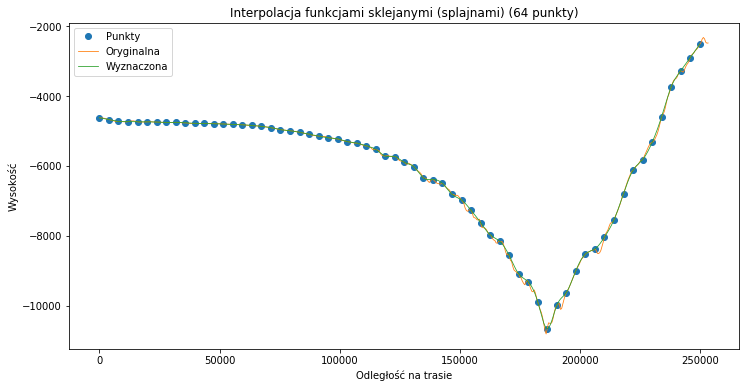

In [287]:
import numpy as np
from scipy.linalg import solve
solved = solve(matrix, vect_y)
#print(solved)
#Tworzenie wykresu
vx = []
vy = []
x = 0
value = 0
for i in range(0, points-1):
    x = mainData[i][0]
    while x < mainData[i+1][0]:
        h = x - mainData[i][0]
        vx.append(x)
        value = solved[4*i] + solved[4*i+1] * h + solved[4*i+2] * (h**2) + solved[4*i+3] * (h**3)
        vy.append(value)
        x += 1
plt.figure(figsize=(12,6))
plt.plot([x[0] for x in mainData], [x[1] for x in mainData], 'o',linewidth=0.8, label = 'Punkty')
plt.plot(data['x'],data['y'], linewidth=0.8, label = 'Oryginalna')
plt.plot(vx, vy, linewidth=0.8, label = 'Wyznaczona')
plt.legend()
pylab.title("Interpolacja funkcjami sklejanymi (splajnami) (64 punkty)")
plt.xlabel("Odległość na trasie")
plt.ylabel("Wysokość")
plt.savefig('GlebiaChallengera_splajny64.png', bbox_inches = 'tight')


In [288]:
size = len(matrix)
L = np.eye(size)
P = np.eye(size)
U = copy.deepcopy(matrix)
ind = 0


for k in range(0, size - 1):
    pivot = -1
    for j in range(k, size):
        if abs(U[j][k]) > pivot:
            pivot = abs(U[j][k])
    for j in range(k, size):
        if(abs(U[j][k]) == pivot):
            ind = j
            break
    for i in range(k, size):
        U[k][i],U[ind][i] = U[ind][i],U[k][i]
    for i in range(k):
        L[k][i],L[ind][i] = L[ind][i],L[k][i]
    for i in range(size):
        P[k][i],P[ind][i] = P[ind][i],P[k][i]
    
    
    for j in range(k+1, size):
        L[j][k] = U[j][k]/U[k][k]
        for i in range(k, size):
            U[j][i] = U[j][i] - L[j][k] * U[k][i]
